# Optimizacion Industrial con Computacion Evolutiva
<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>

Dr. Edwin Villanueva (ervillanueva@pucp.edu.pe)

## Asignación de vuelos a gates en aeropuerto

Esta  notebook implementa un algoritmo genético monoobjetivo para la resolución de la asignación de vuelos a gates. Los operadores de cruzamiento y mutación NO aseguran que los individuos representen vuelos diferentes y gates diferentes.

#### Representacion de Individuo:

Un objeto Individual representaa una determinada asignacion de un subconjunto de vuelos (almacenado en <b>list_of_flights</b>) a un conjunto de gates (almacenado en <b>chromosome</b>). La lista de gates disponibles que se pueden asignar a los vuelos se almacena en la variable <b>allele_pool</b>  del individuo. Ver el siguiente grafico ilustrativo:

<img src="EjemploIndividuoAvion.jpg">



In [112]:
import sys
import time
import numpy as np
import random
from random import choice, seed, randint, sample, uniform, randrange
from copy import deepcopy
import matplotlib.pyplot as plt

### Clase <b>Individual</b>

Esta es una clase para definir a un individuo de la población. Cada individuo posee un cromosoma, los vuelos a asignar, todos los posibles alelos y su respectivo fitness. Además, los métodos de esta clase permiten realizar el cruzamiento (crossover) y la mutación (mutation) sobre el cromosoma del individuo.

In [113]:
# Clase que implementa el individuo y sus operadores
class Individual(object):

    # El constructor recibe la lista de vuelos que representa el individuo y los gates asignados, asi como el pool de flights y gates
    def __init__(self, flights, gates, flights_pool, gates_pool):
        self.flights = flights[:]
        self.gates = gates[:]
        self.flights_pool = flights_pool
        self.gates_pool = gates_pool
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = randrange(len(self.gates))  # escoge aleatoriamento una posicion en la lista gates
        ind1 = Individual(self.flights, self.gates[:c] + other.gates[c:], self.flights_pool, self.gates_pool)
        ind2 = Individual(self.flights, other.gates[:c] + self.gates[c:], self.flights_pool, self.gates_pool)
        return [ind1, ind2]

    def crossover_onepoint_custom(self, other):
        # Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other
        c = randrange(len(self.gates))  # escoge aleatoriamente una posición en la lista gates

        # Crear copias de los padres
        gates_self = self.gates.copy()
        gates_other = other.gates.copy()

        # Crear diccionarios para almacenar la asignación de vuelos a gates
        flight_gate_self = {}
        flight_gate_other = {}

        # Realizar la asignación única de gates a vuelos en los descendientes
        for flight, gate in zip(self.flights, gates_self):
            flight_gate_self[flight] = gate

        for flight, gate in zip(other.flights, gates_other):
            flight_gate_other[flight] = gate

        for flight, gate in zip(self.flights, gates_self):
            if flight in flight_gate_other.values():
                # Si el vuelo ya está asignado en el otro individuo, asignar un gate disponible
                available_gates = [g for g in self.gates if g not in gates_self]
                new_gate = random.choice(available_gates)
                gates_self[gates_self.index(gate)] = new_gate
                flight_gate_self[flight] = new_gate

        for flight, gate in zip(other.flights, gates_other):
            if flight in flight_gate_self.values():
                # Si el vuelo ya está asignado en el otro individuo, asignar un gate disponible
                available_gates = [g for g in other.gates if g not in gates_other]
                new_gate = random.choice(available_gates)
                gates_other[gates_other.index(gate)] = new_gate
                flight_gate_other[flight] = new_gate

        # Crear los nuevos individuos con las asignaciones actualizadas
        ind1 = Individual(self.flights, gates_self, self.flights_pool, self.gates_pool)
        ind2 = Individual(other.flights, gates_other, other.flights_pool, other.gates_pool)
        return [ind1, ind2]

    def crossover_uniform(self, other):
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        gates_ind1 = []
        gates_ind2 = []

        for i in range(len(self.gates)):
            if uniform(0, 1) < 0.5:
                gates_ind1.append(self.gates[i])
                gates_ind2.append(other.gates[i])
            else:
                gates_ind1.append(other.gates[i])
                gates_ind2.append(self.gates[i])
        ind1 = Individual(self.flights, gates_ind1, self.flights_pool, self.gates_pool)
        ind2 = Individual(self.flights, gates_ind2, self.flights_pool, self.gates_pool)
        return [ind1, ind2]

    def crossover_uniform_custom(self, other):
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        gates_ind1 = []  # Lista para almacenar los gates del primer individuo hijo
        gates_ind2 = []  # Lista para almacenar los gates del segundo individuo hijo
        unused_gates = list(self.gates_pool)  # Lista de gates no utilizados
        used_gates = []  # Lista de gates utilizados

        for i in range(len(self.gates)):
            if uniform(0, 1) < 0.5:  # Probabilidad de selección del gate del primer padre
                if self.gates[i] in unused_gates:  # Si el gate del primer padre no ha sido utilizado
                    unused_gates.remove(self.gates[i])  # Eliminar el gate de la lista de no utilizados
                    used_gates.append(self.gates[i])  # Agregar el gate a la lista de utilizados
                    gates_ind1.append(self.gates[i])  # Asignar el gate al primer individuo hijo
                else:
                    gate = choice(unused_gates)  # Seleccionar un gate no utilizado al azar
                    unused_gates.remove(gate)  # Eliminar el gate seleccionado de la lista de no utilizados
                    used_gates.append(gate)  # Agregar el gate a la lista de utilizados
                    gates_ind1.append(gate)  # Asignar el gate al primer individuo hijo
            else:
                if other.gates[i] in unused_gates:  # Si el gate del segundo padre no ha sido utilizado
                    unused_gates.remove(other.gates[i])  # Eliminar el gate de la lista de no utilizados
                    used_gates.append(other.gates[i])  # Agregar el gate a la lista de utilizados
                    gates_ind1.append(other.gates[i])  # Asignar el gate al primer individuo hijo
                else:
                    gate = choice(unused_gates)  # Seleccionar un gate no utilizado al azar
                    unused_gates.remove(gate)  # Eliminar el gate seleccionado de la lista de no utilizados
                    used_gates.append(gate)  # Agregar el gate a la lista de utilizados
                    gates_ind1.append(gate)  # Asignar el gate al primer individuo hijo

        for i in range(len(self.gates)):
            if gates_ind1[i] in used_gates:  # Si el gate ya fue utilizado en gates_ind1
                unused_gates.append(gates_ind1[i])  # Agregar el gate a la lista de no utilizados

        for i in range(len(self.gates)):
            if gates_ind1[i] in unused_gates:  # Si el gate del primer individuo hijo no ha sido utilizado
                unused_gates.remove(gates_ind1[i])  # Eliminar el gate de la lista de no utilizados
                gates_ind2.append(gates_ind1[i])  # Asignar el gate al segundo individuo hijo
            else:
                gate = choice(unused_gates)  # Seleccionar un gate no utilizado al azar
                unused_gates.remove(gate)  # Eliminar el gate seleccionado de la lista de no utilizados
                gates_ind2.append(gate)  # Asignar el gate al segundo individuo hijo

        ind1 = Individual(self.flights, gates_ind1, self.flights_pool,
                          self.gates_pool)  # Crear el primer individuo hijo
        ind2 = Individual(self.flights, gates_ind2, self.flights_pool,
                          self.gates_pool)  # Crear el segundo individuo hijo
        return [ind1, ind2]  # Retornar los individuos hijos generados

    def mutate_position(self):
        "Cambia aleatoriamente el Gate asignado a un Flight."
        mutated_gates = deepcopy(self.gates)
        indexGate = randrange(0, len(self.gates))  # escoge el índice del elemento de gates que será mutado
        newGate = self.gates_pool[randrange(0, len(self.gates_pool))]
        mutated_gates[indexGate] = newGate
        return Individual(self.flights, mutated_gates, self.flights_pool, self.gates_pool)

    def mutate_swap(self):
        "Realiza una mutación de intercambio en el individuo"
        mutated_gates = deepcopy(self.gates)
        index1, index2 = random.sample(range(len(mutated_gates)), 2)
        mutated_gates[index1], mutated_gates[index2] = mutated_gates[index2], mutated_gates[index1]
        return Individual(self.flights, mutated_gates, self.flights_pool, self.gates_pool)

    def mutate_insertion(self):
        "Realiza una mutación de inserción en el individuo"
        mutated_gates = deepcopy(self.gates)
        index1, index2 = random.sample(range(len(mutated_gates)), 2)
        gate = mutated_gates.pop(index1)
        mutated_gates.insert(index2, gate)
        return Individual(self.flights, mutated_gates, self.flights_pool, self.gates_pool)

### Clase <b>Gate</b>

Esta es una clase abstracta para definir los lugares donde los vuelos serán asignados. Se debe hacer subclases con el fin de diferenciar los tipos de lugar donde un vuelo puede ser asignado.

In [114]:
class Gate(object):
    def __init__(self, identifier, x, y, z):
        self.identifier = identifier   # identificador del Gate
        self.distance = x              # en el caso de Sleeve esto almacena la longitud de manga. En el caso de zonas es la distancia a una puerta del aeropuerto 
        self.potential_of_speed = y    # en el caso de Sleeve esto almacena la velocidad de pasajeros en manga. En el caso de zona almacena la velocidad del bus 
        self.number_of_persons_every_10m = z   # en el caso de Sleeve esto almacena el numero de personas cada 10 metros. En el cazo de zona es la capacidad del bus
  
    def __hash__(self):
        return self.identifier

### Clase <b>Sleeve</b>

Esta clase implementa concretamente el Gate tipo Sleeve (Manga). En este tipo de gate, los pasajeros deben realizar un recorrido a pie hasta abandonar totalmente el Gate. Se tiene en cuenta la longitud de la manga, la velocidad de los pasajeros y la cantidad de personas que pueden estar cada 10m (este valor es variable porque ya refleja el ancho de la manga, puesto que una manga más ancha permite una mayor cantidad de pasajeros).

In [115]:
class Sleeve(Gate):
    def __init__(self, identifier, length_of_sleeve, speed_of_passengers_on_sleeve, number_of_passengers_every_10m):
        super().__init__(identifier, length_of_sleeve, speed_of_passengers_on_sleeve, number_of_passengers_every_10m)

### Clase <b>Zone</b>

Esta clase implementa concretamente el Gate tipo Zone (zona). En este tipo de gate, los pasajeros son recogidos por un bus y son llevados hasta una puerta. Se tiene en cuenta la distancia de la zona a la puerta, la velocidad y capacidad del bus.

In [116]:
class Zone(Gate):
    def __init__(self, identifier, distance_zone_door, speed_bus, capacity_of_bus):
        super().__init__(identifier, distance_zone_door, speed_bus, capacity_of_bus)

### Clase <b>Flight</b>

Esta es una clase para definir a los vuelos a asignar. Cada vuelo posee una capacidad máxima, la cantidad de pasajeros, el tiempo de estacionamiento que le toma al vuelo, la longitud de las alas del avión, el tiempo de inspección al avión luego de aterrizar, el tiempo que demorarían en bajar las escaleras los pasajeros si el avión estuviera repleto, el momento de llegada al aeropuerto y el momento en que debería irse del aeropuerto.

In [117]:
class Flight(object):
    def __init__(self, identifier, maximum_capacity, number_of_passengers, parking_time, length_wings, inspection_time, landing_time_on_stairs, arriving_time, leaving_time):
        self.identifier = identifier  # identificador de vuelo
        self.maximum_capacity = maximum_capacity  # maxima capacidad del vuelo
        self.number_of_passengers = number_of_passengers  # numero de pasajeros
        self.parking_time = parking_time   # tiempo de parqueo
        self.length_wings = length_wings   # longitud de las alas
        self.inspection_time = inspection_time  # tiempo de inspeccion
        self.landing_time_on_stairs = landing_time_on_stairs  
        self.arriving_time = arriving_time   # tiempo de llegada al aeropuerto
        self.leaving_time = leaving_time   # tiempo de partida del aeropuerto
  
    def __hash__(self):
        return self.identifier

### Funciones utilitarias para generar los Gates y Vuelos</b>
Estas son funciones utilitarias para generar automáticamente los Gates y Vuelos

In [118]:
# Genera una lista de Gates
def generate_list_of_gates(number_of_gates, max_length_of_sleeve=20, max_speed_of_passengers_on_sleeve=3, max_number_of_passengers_every_10m=12, max_distance_zone_door=50, max_speed_bus=15, max_capacity_of_bus=200):
  list_of_gates = list()

  for gate_identifier in range(number_of_gates):
    gate_type = randint(0, 1)

    if gate_type == 0:   # caso manga
      distance = randint(1, max_length_of_sleeve)
      potential_of_speed = randint(1, max_speed_of_passengers_on_sleeve)
      number_of_persons_every_10m = randint(1, max_number_of_passengers_every_10m)

      gate = Sleeve(gate_identifier, distance, potential_of_speed, number_of_persons_every_10m)
   
    else:    # caso zone
      distance = randint(1, max_distance_zone_door)
      potential_of_speed = randint(1, max_speed_bus)
      number_of_persons_every_10m = randint(1, max_capacity_of_bus)

      gate = Zone(gate_identifier, distance, potential_of_speed, number_of_persons_every_10m)
    
    list_of_gates.append(gate)
  
  return list_of_gates

# Genera una lista de Flights
def generate_list_of_flights(number_of_flights, max_maximum_capacity=100, max_number_of_passengers_factor=0.8, max_parking_time=30, max_length_wings=25, max_inspection_time=180, max_landing_time_on_stairs=60, max_arriving_time=200, max_leaving_time=1000):
  list_of_flights = list()

  max_number_of_passengers = max_number_of_passengers_factor * max_maximum_capacity

  for flight_identifier in range(number_of_flights):
    maximum_capacity = randint(max_number_of_passengers, max_maximum_capacity)
    number_of_passengers = randint(1, max_number_of_passengers)
    parking_time = randint(1, max_parking_time)
    length_wings = randint(1, max_length_wings)
    inspection_time = randint(1, max_inspection_time)
    landing_time_on_stairs = randint(1, max_landing_time_on_stairs)
    arriving_time = randint(1, max_arriving_time)
    leaving_time = randint(max_arriving_time + 1, max_leaving_time)

    flight = Flight(flight_identifier, maximum_capacity, number_of_passengers, parking_time, length_wings, inspection_time, landing_time_on_stairs, arriving_time, leaving_time)
    
    list_of_flights.append(flight)
  
  return list_of_flights

### Funciones utilitarias para ordenar los Vuelos y Gates</b>
Estas son funciones utilitarias para ordenar los Vuelos acorde a su deseabilidad y los Gates por su flujo personas

In [119]:
# Funcion para ordenar vuelos por su grado de deseabilidad  ( nro_pasajeros/tiempo_en_aeropuerto )
def process_desirability(n):
  return n.number_of_passengers / (n.leaving_time - n.arriving_time)

# Funcion para ordenar Gates por su capacidad de flujo de personas  
def process_flow(n):
  return n.number_of_persons_every_10m * n.potential_of_speed * 10 / n.distance

### Funciones utilitarias para el Algoritmo Genético</b>
Estas son funciones utilitarias para realizar el Algoritmo Genético que se encargue de la asignación de vuelos

In [120]:
# Inicialización aleatoria de la población
def init_population(population_number, flights_to_assign, list_of_flights, list_of_gates):
  population = []
  for i in range(population_number):
    flights = sample(list_of_flights, flights_to_assign)  # escoge los vuelos del individuo
    gates = sample(list_of_gates, flights_to_assign) # escoge los gates del individuo
    
    population.append( Individual(flights, gates, list_of_flights, list_of_gates) )
  return population

In [121]:
# Evalua una individuo representado por sus listas:  flights, gates
def fitness(flights, gates):
  grace_time = 5/100

  cumulative_efficiency = 0
  for flight, gate in zip(flights, gates):
    number_of_passengers = flight.number_of_passengers
    if isinstance(gate, Sleeve):  # si el gate es de tipo Manga 
      disembarkation_time_of_passengers = ( (number_of_passengers * (gate.distance + flight.length_wings) / process_flow(gate)) + flight.parking_time + flight.inspection_time ) * (1 + grace_time)
    else:  # si el gate es de tipo Zona
      disembarkation_time_of_passengers = ( (number_of_passengers * gate.distance / process_flow(gate)) + flight.parking_time + (flight.landing_time_on_stairs * number_of_passengers / flight.maximum_capacity) + flight.inspection_time ) * (1 + grace_time)
    
    # la eficiencia de una asignacion flight-gate es la cantidad total de pasajeros desembarcados por unidad de tiempo
    cumulative_efficiency += number_of_passengers / disembarkation_time_of_passengers
  return cumulative_efficiency


In [122]:
# Evaluar la población con la función fitness
def evaluate_population(population, fitness_fn):
  """ Evalua una poblacion de individuos con la funcion de fitness pasada """
  population_size = len(population)
  for i in range(population_size):
    if population[i].fitness == -1:    # Evalúa sólo si el individuo no esta evaluado
      population[i].fitness = fitness_fn(population[i].flights, population[i].gates)

In [123]:
# Selección de padres por el método roulette
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
    
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

In [124]:
# Selección de padres por el método de torneo
def select_parents_tournament(population, tournament_size):
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

In [125]:
# Selección de la nueva población con metodo de ranking
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    survivors = sorted(population, key=lambda x: x.fitness, reverse=True)[:numsurvivors]
    next_population.extend(survivors)
    return next_population

### Algoritmo Genético

In [143]:
def genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations,
                      selection_fn="roulette", crossover="onepoint", mutation="position", p_mut=0.1):
    #seed(0)

    #Inicializa una poblacion inicial de forma aleatoria
    population = init_population(num_individuals, flights_to_assign, list_of_flights, list_of_gates)

    population_size = len(population)
    evaluate_population(population, fitness_fn)

    best_ind = sorted(population, key=lambda x: x.fitness, reverse=True)[0]  # mejor individuo
    bestfitness = [best_ind.fitness]  # guarda el fitness del mejor individuo
    print("Poblacion inicial, best_fitness = {}".format(best_ind.fitness))

    for g in range(n_generations):  # ciclo evolutivo

        ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
        mating_pool = []
        for i in range(int(population_size / 2)):
            if selection_fn == "roulette":
                mating_pool.append(select_parents_roulette(population))
            elif selection_fn == "tournament":
                mating_pool.append(select_parents_tournament(population, 3))  #torneo de tamaño 3
            else:
                raise NotImplementedError

        ## Crea la poblacion descendencia cruzando las parejas del mating pool
        offspring_population = []
        for i in range(len(mating_pool)):
            if crossover == "onepoint":
                offspring_population.extend(mating_pool[i][0].crossover_onepoint(mating_pool[i][1]))
            elif crossover == "onepoint_custom":
                offspring_population.extend(mating_pool[i][0].crossover_onepoint_custom(mating_pool[i][1]))
            elif crossover == "uniform":
                offspring_population.extend(mating_pool[i][0].crossover_uniform(mating_pool[i][1]))
            elif crossover == "uniform_custom":
                offspring_population.extend(mating_pool[i][0].crossover_uniform_custom(mating_pool[i][1]))
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if uniform(0, 1) < p_mut:
                if mutation == "position":
                    offspring_population[i] = offspring_population[i].mutate_position()
                elif mutation == "swap":
                    offspring_population[i] = offspring_population[i].mutate_swap()
                elif mutation == "insertion":
                    offspring_population[i] = offspring_population[i].mutate_insertion()
                else:
                    raise NotImplementedError

        ## Evalua la población descendencia creada
        evaluate_population(offspring_population, fitness_fn)

        ## Selecciona individuos para la siguiente generación con el método de ranking
        population = select_survivors_ranking(population, offspring_population, population_size)  #metodo de ranking

        ## Almacena la historia del fitness del mejor individuo
        best_ind = sorted(population, key=lambda x: x.fitness, reverse=True)[0]  # mejor individuo de la poblacion actual
        bestfitness.append(best_ind.fitness)

        # if (g % 100 == 0):  # muestra resultados cada 10 generaciones
            # print("generacion {}, (Mejor fitness = {})".format(g, best_ind.fitness))

    return best_ind, bestfitness  # devuelve el mejor individuo y la lista de mejores fitness x gen

### Funciones utilitarias para manejar la solución del Algoritmo Genético</b>
Esta es una función utilitarias que permite mostrar la configuración usada en el Algoritmo Genético y la asignación de Vuelos a Gates encontrada en un individuo pasado (ind)

In [145]:
def make_solution_report(ind, selection_fn, crossover, mutation, pmut):
    print("Selection: {} - Crossover: {} - Mutation: {} - pmut: {} - Fitness: {}".format(selection_fn, crossover, mutation, pmut, ind.fitness), flush=True)

    assigned_gates = {}
    violates_constraints = False

    for flight, gate in zip(ind.flights, ind.gates):
        if gate.identifier in assigned_gates:
            assigned_gates[gate.identifier].append(flight.identifier)
            violates_constraints = True
        else:
            assigned_gates[gate.identifier] = [flight.identifier]

    if violates_constraints:
        # print("El algoritmo genético no cumple con las políticas establecidas", flush=True)
        return False
    else:
        # print("\n".join(["Flight {} in {} {}".format(flight.identifier, "Zone" if isinstance(gate, Zone) == True else "Sleeve", gate.identifier) for flight, gate in zip(ind.flights, ind.gates)]) + "\n", flush=True)
        return True

## <b>Probando el Algoritmo Genético</b> 

### <b>Generación de Gates y Vuelos</b> 

Genera los Gates y Vuelos para que el Algoritmo Genético  realize la asignacion. Asegura que el numero de vuelos a asignar (**flights_to_assign**) no sea mayor a la cantidad de puertas 

In [130]:
seed(0)

number_of_gates = 70
number_of_flights = 300

# general los vuelos y gates
list_of_gates = generate_list_of_gates(number_of_gates)
list_of_flights = generate_list_of_flights(number_of_flights)

# obtiene el número de vuelos que el algoritmo genético puede asignar (no puede ser mayor al número de gates disponibles)
flights_to_assign = number_of_flights if number_of_flights <= number_of_gates else number_of_gates

# ordena los vuelos por su deseabilidad y los gates por su capacidad de flujo de personas
list_of_flights = sorted(list_of_flights, key=process_desirability, reverse=True)
list_of_gates = sorted(list_of_gates, key=process_flow, reverse=True)

### <b>Experimentación con el Algoritmo Genético</b> 

Poblacion inicial, best_fitness = 3.691708624803752
generacion 0, (Mejor fitness = 3.885975007304972)
generacion 100, (Mejor fitness = 5.236515818027379)
generacion 200, (Mejor fitness = 5.236515818027379)
generacion 300, (Mejor fitness = 5.236515818027379)
generacion 400, (Mejor fitness = 5.236515818027379)
generacion 500, (Mejor fitness = 5.236515818027379)
generacion 600, (Mejor fitness = 5.236515818027379)
generacion 700, (Mejor fitness = 5.236515818027379)
generacion 800, (Mejor fitness = 5.236515818027379)
generacion 900, (Mejor fitness = 5.236515818027379)


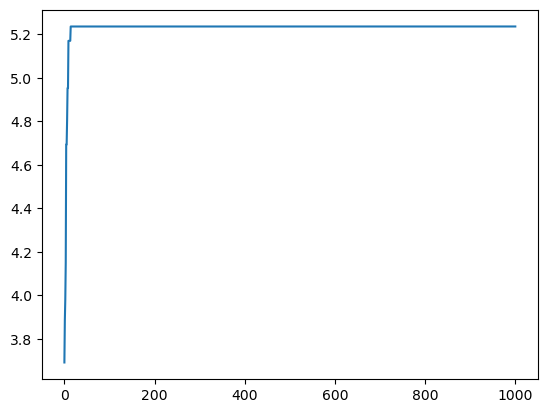

Selection: roulette - Crossover: uniform - Mutation: position - pmut: 0 - Fitness: 5.236515818027379
El algoritmo genético no cumple con las restricciones


False

In [139]:
num_individuals = 50

fitness_fn = fitness
n_generations = 1000

best_fitness = 0

selection_fn = "roulette"
crossover = "uniform" # onepoint, onepoint_custom, uniform, uniform_custom
mutation = "position" # position, swap, insertion
p_mut = 0

# Realiza la asignacion con el algoritmo genetico
best_ind, bestfitness = genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign, fitness_fn, n_generations, selection_fn, crossover, mutation, p_mut)

# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()

# imprime la mejor solucion
make_solution_report(best_ind, selection_fn, crossover, mutation, p_mut)

In [ ]:
from random import seed
import matplotlib.pyplot as plt
import statistics

# Configuración de semilla aleatoria para reproducibilidad
seed(0)

number_of_gates = 10
number_of_flights = 30

# Generar los vuelos y gates
list_of_gates = generate_list_of_gates(number_of_gates)
list_of_flights = generate_list_of_flights(number_of_flights)

# Obtener el número de vuelos que el algoritmo genético puede asignar
flights_to_assign = min(number_of_flights, number_of_gates)

# Ordenar los vuelos por deseabilidad y los gates por capacidad de flujo de personas
list_of_flights = sorted(list_of_flights, key=process_desirability, reverse=True)
list_of_gates = sorted(list_of_gates, key=process_flow, reverse=True)

num_individuals = 50
fitness_fn = fitness
n_generations =300
selection_fn = "roulette"

best_run_ind = {}
best_run_fitness = [0]
best_config_ind = {}
best_config_fitness = [0]
best_config = {}

# onepoint, onepoint_custom, uniform, uniform_custom
# position, swap, insertion

# Configuración de los experimentos
configurations = [
    {"crossover": "uniform", "mutation": "position", "p_mut": 0.05, "runs": 10},
    {"crossover": "uniform", "mutation": "position", "p_mut": 0.5, "runs": 10},
    {"crossover": "uniform", "mutation": "position", "p_mut": 1, "runs": 10},
    {"crossover": "uniform", "mutation": "swap", "p_mut": 0.05, "runs": 10},
    {"crossover": "uniform", "mutation": "swap", "p_mut": 0.5, "runs": 10},
    {"crossover": "uniform", "mutation": "swap", "p_mut": 1, "runs": 10},
    {"crossover": "uniform", "mutation": "insertion", "p_mut": 0.05, "runs": 10},
    {"crossover": "uniform", "mutation": "insertion", "p_mut": 0.5, "runs": 10},
    {"crossover": "uniform", "mutation": "insertion", "p_mut": 1, "runs": 10},

    {"crossover": "uniform_custom", "mutation": "position", "p_mut": 0.05, "runs": 10},
    {"crossover": "uniform_custom", "mutation": "position", "p_mut": 0.5, "runs": 10},
    {"crossover": "uniform_custom", "mutation": "position", "p_mut": 1, "runs": 10},
    {"crossover": "uniform_custom", "mutation": "swap", "p_mut": 0.05, "runs": 10},
    {"crossover": "uniform_custom", "mutation": "swap", "p_mut": 0.5, "runs": 10},
    {"crossover": "uniform_custom", "mutation": "swap", "p_mut": 1, "runs": 10},
    {"crossover": "uniform_custom", "mutation": "insertion", "p_mut": 0.05, "runs": 10},
    {"crossover": "uniform_custom", "mutation": "insertion", "p_mut": 0.5, "runs": 10},
    {"crossover": "uniform_custom", "mutation": "insertion", "p_mut": 1, "runs": 10},

    {"crossover": "onepoint", "mutation": "position", "p_mut": 0.05, "runs": 10},
    {"crossover": "onepoint", "mutation": "position", "p_mut": 0.5, "runs": 10},
    {"crossover": "onepoint", "mutation": "position", "p_mut": 1, "runs": 10},
    {"crossover": "onepoint", "mutation": "swap", "p_mut": 0.05, "runs": 10},
    {"crossover": "onepoint", "mutation": "swap", "p_mut": 0.5, "runs": 10},
    {"crossover": "onepoint", "mutation": "swap", "p_mut": 1, "runs": 10},
    {"crossover": "onepoint", "mutation": "insertion", "p_mut": 0.05, "runs": 10},
    {"crossover": "onepoint", "mutation": "insertion", "p_mut": 0.5, "runs": 10},
    {"crossover": "onepoint", "mutation": "insertion", "p_mut": 1, "runs": 10},

    {"crossover": "onepoint_custom", "mutation": "position", "p_mut": 0.05, "runs": 10},
    {"crossover": "onepoint_custom", "mutation": "position", "p_mut": 0.5, "runs": 10},
    {"crossover": "onepoint_custom", "mutation": "position", "p_mut": 1, "runs": 10},
    {"crossover": "onepoint_custom", "mutation": "swap", "p_mut": 0.05, "runs": 10},
    {"crossover": "onepoint_custom", "mutation": "swap", "p_mut": 0.5, "runs": 10},
    {"crossover": "onepoint_custom", "mutation": "swap", "p_mut": 1, "runs": 10},
    {"crossover": "onepoint_custom", "mutation": "insertion", "p_mut": 0.05, "runs": 10},
    {"crossover": "onepoint_custom", "mutation": "insertion", "p_mut": 0.5, "runs": 10},
    {"crossover": "onepoint_custom", "mutation": "insertion", "p_mut": 1, "runs": 10}
]

# Realizar los experimentos para cada configuración
for config in configurations:
    crossover = config["crossover"]
    mutation = config["mutation"]
    p_mut = config["p_mut"]
    runs = config["runs"]

    best_fitness_values = []

    for run in range(runs):
        # Realizar una corrida del algoritmo genético
        best_ind, best_fitness = genetic_algorithm(list_of_flights, list_of_gates, num_individuals, flights_to_assign,
                                                   fitness_fn, n_generations, selection_fn, crossover, mutation, p_mut)
        best_fitness_values.append(best_fitness[-1])  # Guardar el mejor fitness de la última generación

        # imprime la mejor solucion
        isValid = make_solution_report(best_ind, selection_fn, crossover, mutation, p_mut)

        if isValid and best_run_fitness[-1] < best_fitness[-1]:
            best_run_fitness = best_fitness
            best_run_ind = best_ind

        if not isValid:
            break

    if len(best_fitness_values) == 10:
        # Calcular estadísticas de los mejores fitness
        avg_best_fitness = statistics.mean(best_fitness_values)
        std_best_fitness = statistics.stdev(best_fitness_values)

        # print("Configuración:")
        # print(f"Crossover: {crossover}, Mutación: {mutation}, Tasa de mutación: {p_mut}")
        print(f"Promedio del mejor fitness: {avg_best_fitness}")
        print(f"Desviación estándar del mejor fitness: {std_best_fitness}")
        print()

        if best_config_fitness[-1] < best_run_fitness[-1]:
            best_config_fitness = best_run_fitness
            best_config_ind = best_run_ind
            best_config = config

    # Visualizar la evolución del mejor fitness para la última corrida
    # plt.plot(best_run_fitness)
    # plt.xlabel("Generación")
    # plt.ylabel("Fitness")
    # plt.title("Evolución del Mejor Fitness")
    # plt.show()

crossover = best_config["crossover"]
mutation = best_config["mutation"]
p_mut = best_config["p_mut"]

print("Configuración:")
print(f"Crossover: {crossover}, Mutación: {mutation}, Tasa de mutación: {p_mut}")
print()

# Visualizar la evolución del mejor fitness para la última corrida
plt.plot(best_config_fitness)
plt.xlabel("Generación")
plt.ylabel("Fitness")
plt.title("Evolución del Mejor Fitness")
plt.show()

# imprime la mejor solucion
make_solution_report(best_config_ind, selection_fn, crossover, mutation, p_mut)

Poblacion inicial, best_fitness = 3.544561112646607
Selection: roulette - Crossover: uniform - Mutation: position - pmut: 0.05 - Fitness: 5.394994592056581
Poblacion inicial, best_fitness = 3.8636186045728125
Selection: roulette - Crossover: uniform - Mutation: position - pmut: 0.5 - Fitness: 5.485031705269262
Poblacion inicial, best_fitness = 3.98185265636702
Selection: roulette - Crossover: uniform - Mutation: position - pmut: 1 - Fitness: 5.597203563597659
Poblacion inicial, best_fitness = 4.052971913705613
Selection: roulette - Crossover: uniform - Mutation: swap - pmut: 0.05 - Fitness: 5.820709587460658
Poblacion inicial, best_fitness = 3.7707927287015917
Selection: roulette - Crossover: uniform - Mutation: swap - pmut: 0.5 - Fitness: 6.073637083594832
Poblacion inicial, best_fitness = 3.506496373949967
Selection: roulette - Crossover: uniform - Mutation: swap - pmut: 1 - Fitness: 5.384568148364048
Poblacion inicial, best_fitness = 3.658022674438334
Selection: roulette - Crossover